In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import time
import warnings
import cv2
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import albumentations as A
import matplotlib.pyplot as plt
import PIL

warnings.filterwarnings("ignore")

In [ ]:
!pip install git+https://github.com/yxxshin/yxx_change_detection.pytorch > /dev/null 2>&1
import change_detection_pytorch as cdp

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [ ]:
def seed_torch(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch(seed = 10)

In [ ]:
## TODO
DATASET_PATH = '/content/drive/MyDrive/MAICON_Preround/y2_factory/'

In [ ]:
def make_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
import zipfile
from tqdm import tqdm

make_dir('/content/datasets/')
make_dir('/content/datasets/train/')
make_dir('/content/datasets/train/y2')
make_dir('/content/datasets/train/y2_train_x1')
make_dir('/content/datasets/train/y2_train_x2')
make_dir('/content/datasets/val/')
make_dir('/content/datasets/val/y2')
make_dir('/content/datasets/val/y2_train_x1')
make_dir('/content/datasets/val/y2_train_x2')

with zipfile.ZipFile(DATASET_PATH + 'train_y2.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/train/y2')

with zipfile.ZipFile(DATASET_PATH + 'train_y2_train_x1.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/train/y2_train_x1')

with zipfile.ZipFile(DATASET_PATH + 'train_y2_train_x2.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/train/y2_train_x2')

with zipfile.ZipFile(DATASET_PATH + 'val_y2.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/val/y2')

with zipfile.ZipFile(DATASET_PATH + 'val_y2_train_x1.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/val/y2_train_x1')

with zipfile.ZipFile(DATASET_PATH + 'val_y2_train_x2.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/val/y2_train_x2')

Extracting  : 100%|██████████| 2327/2327 [00:11<00:00, 206.02it/s]


In [ ]:
from change_detection_pytorch.datasets.custom import CustomDataset

class SatelliteDataset(CustomDataset):
  def __init__(self, img_dir, sub_dir_1, sub_dir_2, ann_dir, img_suffix, 
               seg_map_suffix, transform = None, split = None, data_root = None, test_mode = False, size = 256, debug = False):
    super().__init__(img_dir, sub_dir_1, sub_dir_2, ann_dir, img_suffix,
                     seg_map_suffix, transform, split, data_root, test_mode, size, debug)
    
  def get_default_transform(self):
    """ Default Transformation (Train data) """
    
    default_transform = A.Compose([
        A.OneOf(
            [
              A.HorizontalFlip(p = 1),
              A.VerticalFlip(p = 1),
              A.RandomRotate90(p = 1),
            ],
            p = 0.75,
        ),
        # A.CLAHE(clip_limit = (1, 15), tile_grid_size = (8, 8), p = 1),
        A.Equalize(always_apply = True, mode = 'cv', by_channels = False),
        # A.GaussNoise(always_apply = False, p = 0.5, var_limit = (0.0, 26.85)),
        A.Resize(256, 256),
        A.pytorch.ToTensorV2()
    ], additional_targets = {'image_2': 'image'})

    return default_transform
  
  def get_test_transform(self):
    """ Test Transformation """
    
    test_transform = A.Compose([
        A.Resize(256, 256),
        A.pytorch.ToTensorV2()
    ], additional_targets = {'image_2': 'image'})

    return test_transform
  

  def __getitem__(self, idx):
    if not self.ann_dir:
      # Test Data
      img1, img2, fname = self.prepare_img(idx)
      transformed_data = self.transform(image = img1, image_2 = img2)
      img1, img2 = transformed_data['image'], transformed_data['image_2']
      img1 = img1.type(torch.FloatTensor)
      img2 = img2.type(torch.FloatTensor)
      return img1, img2, fname
    
    else:
      img1, img2, ann, fname = self.prepare_img_ann(idx)
      transformed_data = self.transform(image = img1, image_2 = img2, mask = ann)
      img1, img2, ann = transformed_data['image'], transformed_data['image_2'], transformed_data['mask']
      img1 = img1.type(torch.FloatTensor)
      img2 = img2.type(torch.FloatTensor)
      ann = ann.type(torch.FloatTensor)
      return img1, img2, ann, fname


In [ ]:
from matplotlib import colors

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

In [ ]:
train_y2_dataset = SatelliteDataset('/content/datasets/train',
                                sub_dir_1 = 'y2_train_x1',
                                sub_dir_2 = 'y2_train_x2',
                                img_suffix = '.png',
                                ann_dir = '/content/datasets/train/y2',
                                seg_map_suffix = '.png',
                                size = 754,
                                debug = False)

valid_y2_dataset = SatelliteDataset('/content/datasets/val',
                                 sub_dir_1 = 'y2_train_x1',
                                 sub_dir_2 = 'y2_train_x2',
                                 img_suffix = '.png',
                                 ann_dir = '/content/datasets/val/y2',
                                 seg_map_suffix = '.png',
                                 debug = False,
                                 test_mode = True)

Loaded 9270 images
Loaded 2327 images


In [ ]:
train_y2_loader = DataLoader(train_y2_dataset, batch_size = 1, shuffle = True, num_workers = 0)
valid_y2_loader = DataLoader(valid_y2_dataset, batch_size = 1, shuffle = False, num_workers = 0)

2017_DJG_3LB_000046.png
torch.Size([256, 256])
torch.Size([3, 256, 256])


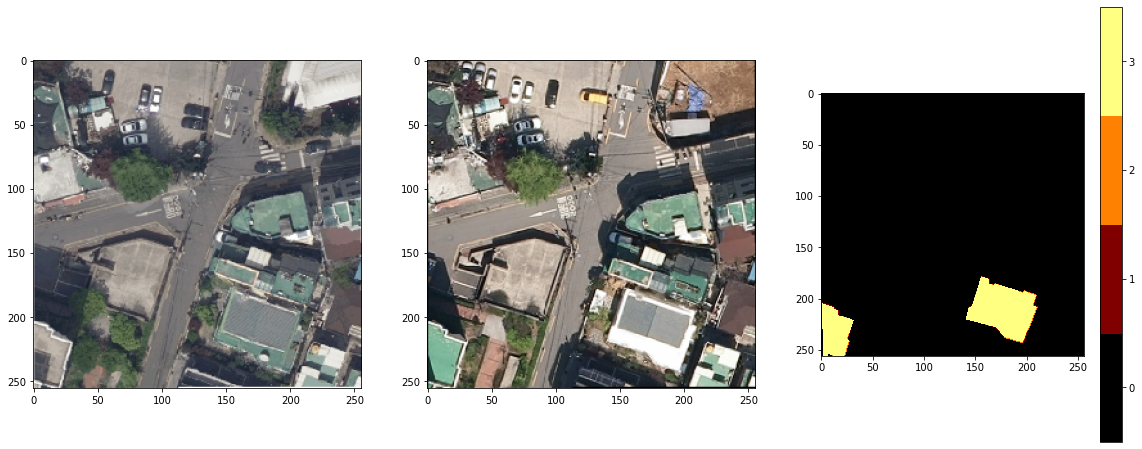

In [ ]:
# DataLoader Sanity Check

it = iter(valid_y2_loader)
test = next(it)
test = next(it)
test_x1, test_x2, test_y, test_filename = test

# Change back to uint8 for visualization
test_x1 = test_x1.type(torch.ByteTensor)
test_x2 = test_x2.type(torch.ByteTensor)
test_y = test_y.type(torch.ByteTensor)

print(test_filename[0]) 
print(test_y[0].shape)    # [256, 256]
print(test_x1[0].shape)   # [3, 256, 256]

plt.figure(figsize = (20, 8))
plt.subplot(131)
plt.imshow(test_x1[0].permute(1, 2, 0))

plt.subplot(132)
plt.imshow(test_x2[0].permute(1, 2, 0))

plt.subplot(133)
plt.imshow(test_y[0], cmap = discrete_cmap(4, 'afmhot'))     # plt.scatter?
plt.colorbar(ticks = range(4))
plt.clim(-0.5, 3.5)
plt.show()

In [ ]:
## TRAINING START

metrics = [
    cdp.utils.metrics.Accuracy(activation = 'argmax2d'),
    cdp.utils.metrics.IoU(activation = 'argmax2d')
]

In [ ]:
from change_detection_pytorch.unetplusplus.model import UnetPlusPlus
from change_detection_pytorch.stanet.model import STANet

model_y2 = UnetPlusPlus(
    encoder_name = 'timm-efficientnet-b3',
    encoder_depth = 5,
    encoder_weights = 'noisy-student',
    in_channels = 3,
    classes = 4,
)

In [ ]:
### train_y2

def train_by_wandb_y2():
  # wandb.init(project = 'MAICON', entity = 'maicon-rokdcc')

  # model_y2 = UnetPlusPlus(
  #   encoder_name = 'timm-regnety_032',
  #   encoder_depth = 5,
  #   encoder_weights = 'imagenet',
  #   in_channels = 3,
  #   classes = 4,
  #   siam_encoder = True,
  #   fusion_form = 'diff',
  #   decoder_channels = [384, 256, 128, 64, 32],
  #   head = 'cond'
  # )
  
  train_loader = DataLoader(train_y2_dataset, batch_size = 16, shuffle = True, num_workers = 0)
  valid_loader = DataLoader(valid_y2_dataset, batch_size = 1, shuffle = False, num_workers = 0)

  loss1 = cdp.losses.JaccardLoss(mode = 'multiclass')
  loss2 = cdp.losses.DiceLoss(mode = 'multiclass')
  loss = cdp.losses.HybridLoss(loss1, loss2)
  # loss = cdp.losses.FocalLoss(mode = 'multiclass')
    
  optimizer = optim.AdamW([
      dict(params = model_y2.parameters(), lr = 1e-4)
  ])

  epochs = 50

  scheduler_steplr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000, eta_min = 0, last_epoch = -1, verbose = False)
    
  train_epoch = cdp.utils.train.TrainEpoch(
      model_y2,
      loss = loss,
      metrics = metrics,
      optimizer = optimizer,
      device = DEVICE,
      verbose = True,
  )

  valid_epoch = cdp.utils.train.ValidEpoch(
      model_y2,
      loss = loss,
      metrics = metrics,
      device = DEVICE,
      verbose = True,
  )

  min_score = 1000
  MAX_EPOCH = epochs

  for i in range(1, MAX_EPOCH + 1):
    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)  
    valid_logs = valid_epoch.run(valid_loader)
    scheduler_steplr.step()
    print('train_logs ', train_logs)
    print('valid_logs ', valid_logs)

    if min_score > valid_logs['HybridLoss']:
      min_score = valid_logs['HybridLoss']
      print('min_loss', min_score)
      torch.save(model_y2, './best_model_y2.pth')
      print('Model saved!')


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_by_wandb_y2()


Epoch: 1
valid: 100%|██████████| 2327/2327 [03:47<00:00, 10.22it/s, HybridLoss - 0.1831, accuracy - 0.9121, iou_score - 0.7129]
train_logs  {'HybridLoss': 0.405985806265782, 'accuracy': 0.8537596110639901, 'iou_score': 0.6098479532476132}
valid_logs  {'HybridLoss': 0.18313751330652836, 'accuracy': 0.9120520709357033, 'iou_score': 0.712902864561725}
min_loss 0.18313751330652836
Model saved!

Epoch: 2
valid: 100%|██████████| 2327/2327 [03:48<00:00, 10.19it/s, HybridLoss - 0.1667, accuracy - 0.9179, iou_score - 0.7812]
train_logs  {'HybridLoss': 0.2885381476247105, 'accuracy': 0.9136079728603365, 'iou_score': 0.7885507768598092}
valid_logs  {'HybridLoss': 0.16667819796366193, 'accuracy': 0.9179277407749062, 'iou_score': 0.781157665456248}
min_loss 0.16667819796366193
Model saved!

Epoch: 3
valid: 100%|██████████| 2327/2327 [03:48<00:00, 10.20it/s, HybridLoss - 0.1595, accuracy - 0.9152, iou_score - 0.8502]
train_logs  {'HybridLoss': 0.2705169480679366, 'accuracy': 0.9160158809916729, 'io

KeyboardInterrupt: ignored

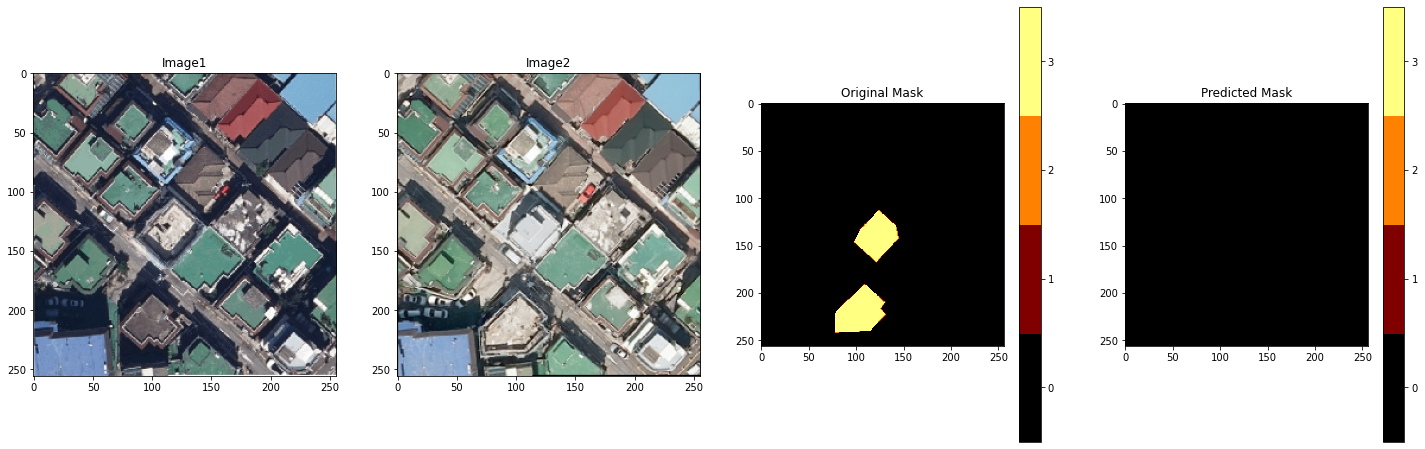

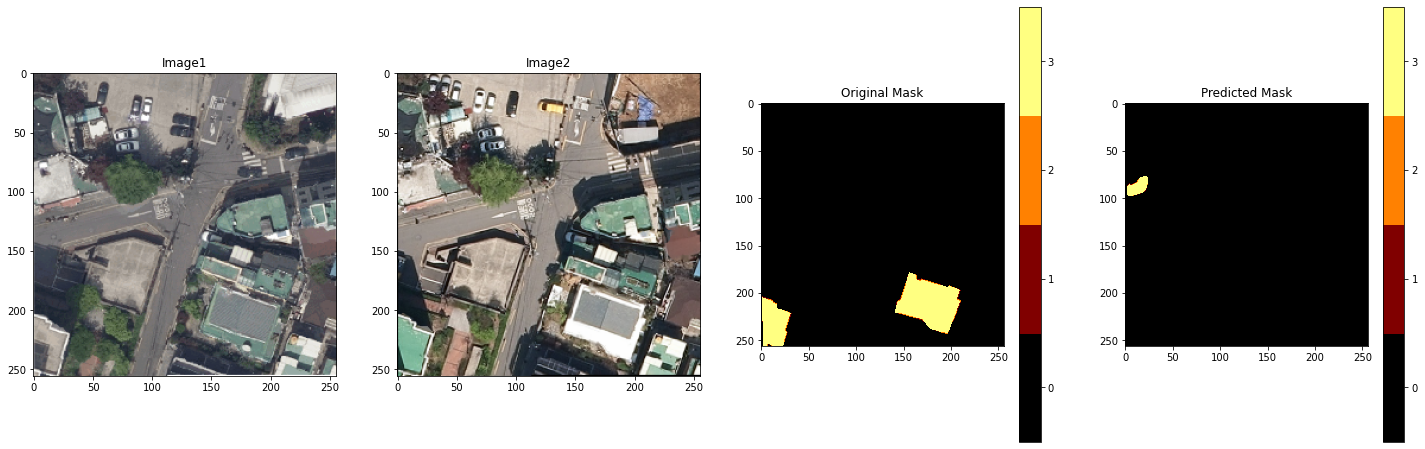

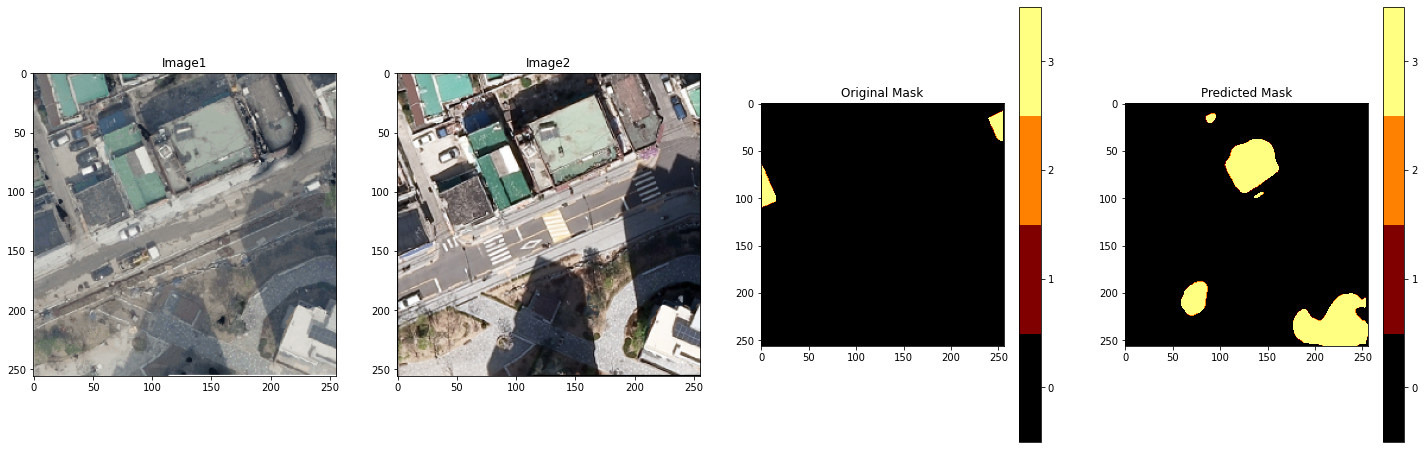

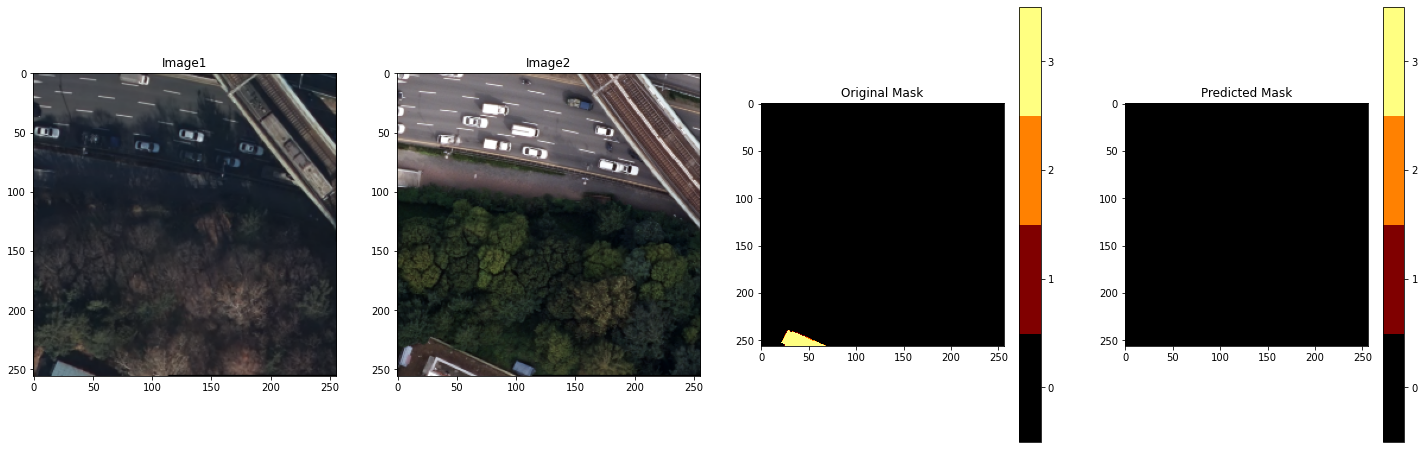

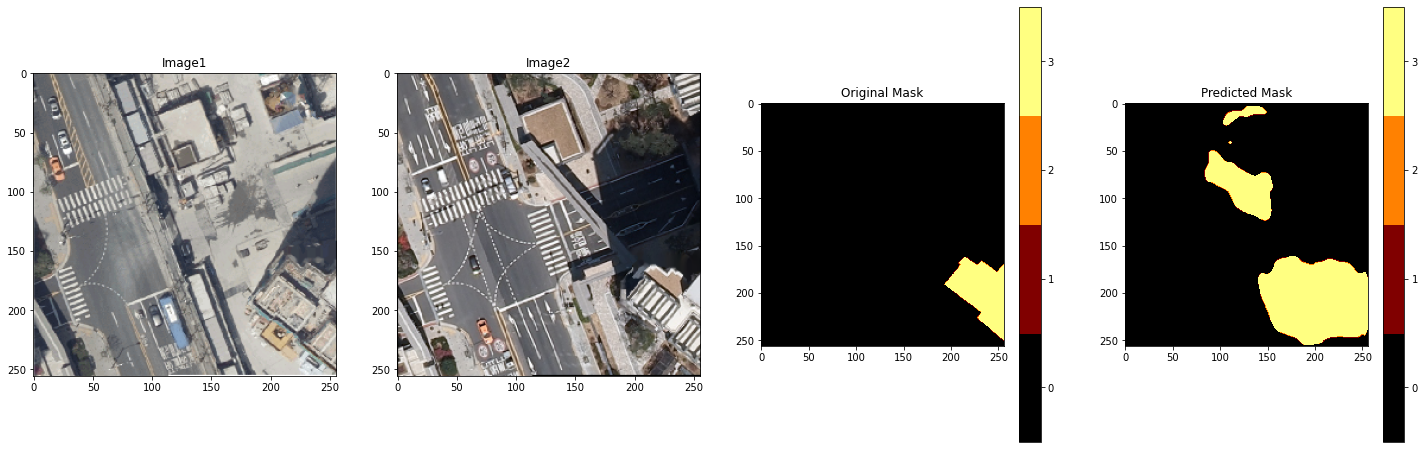

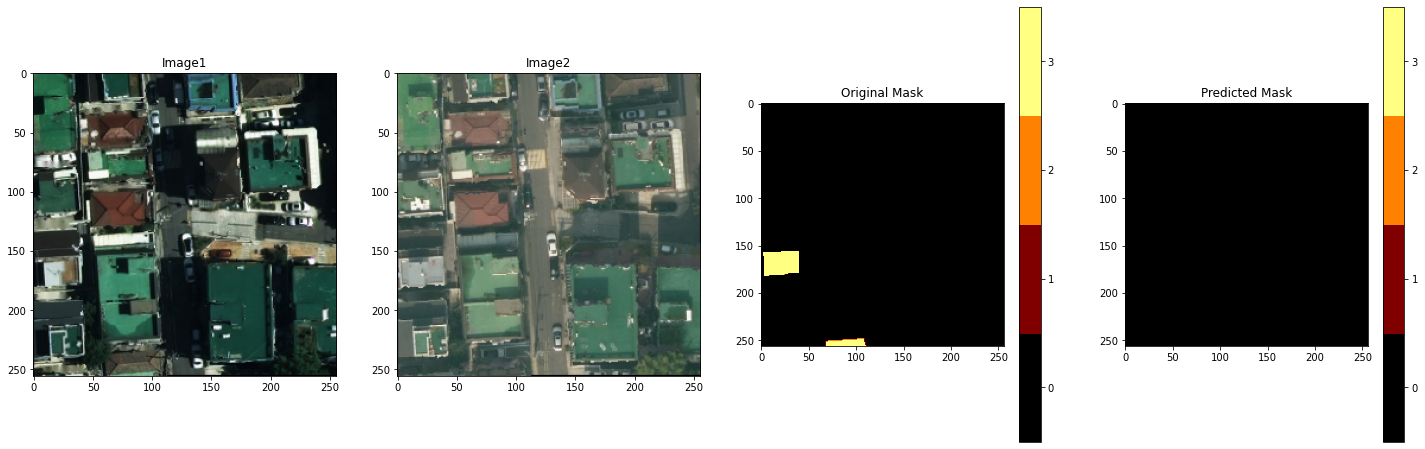

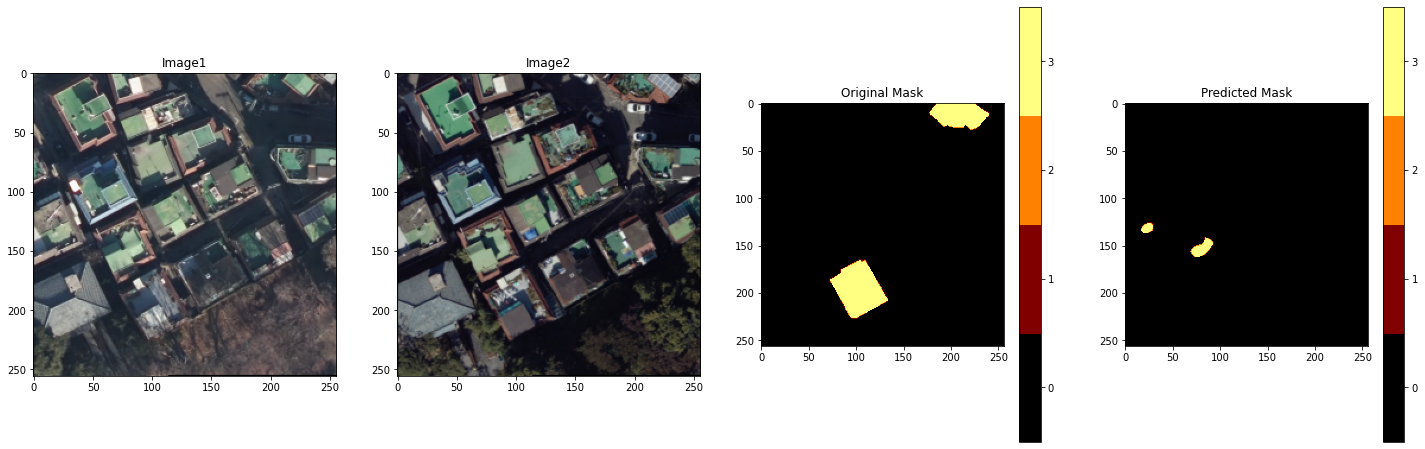

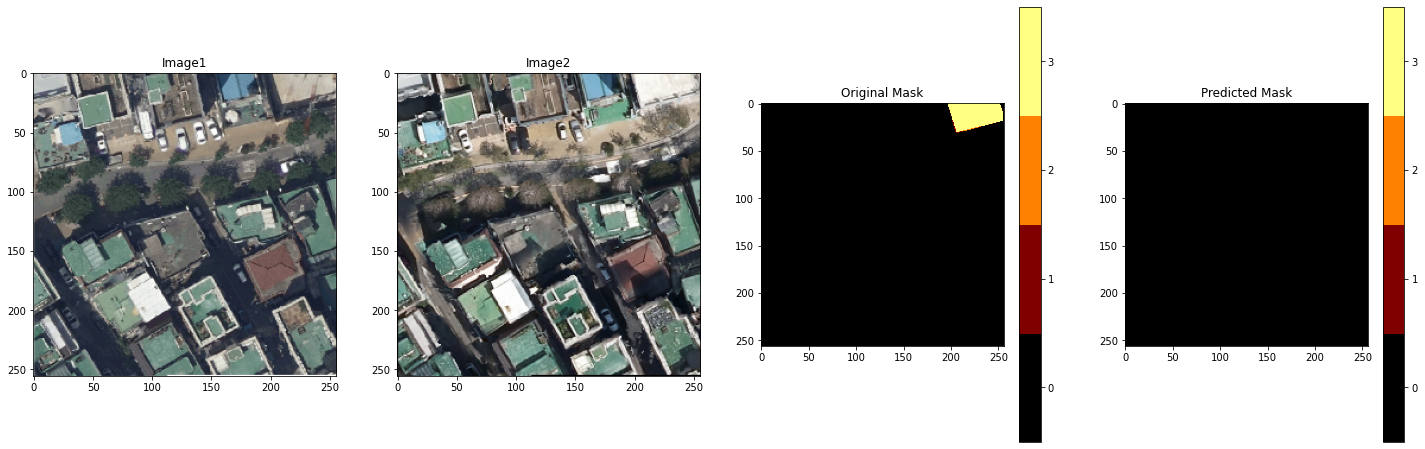

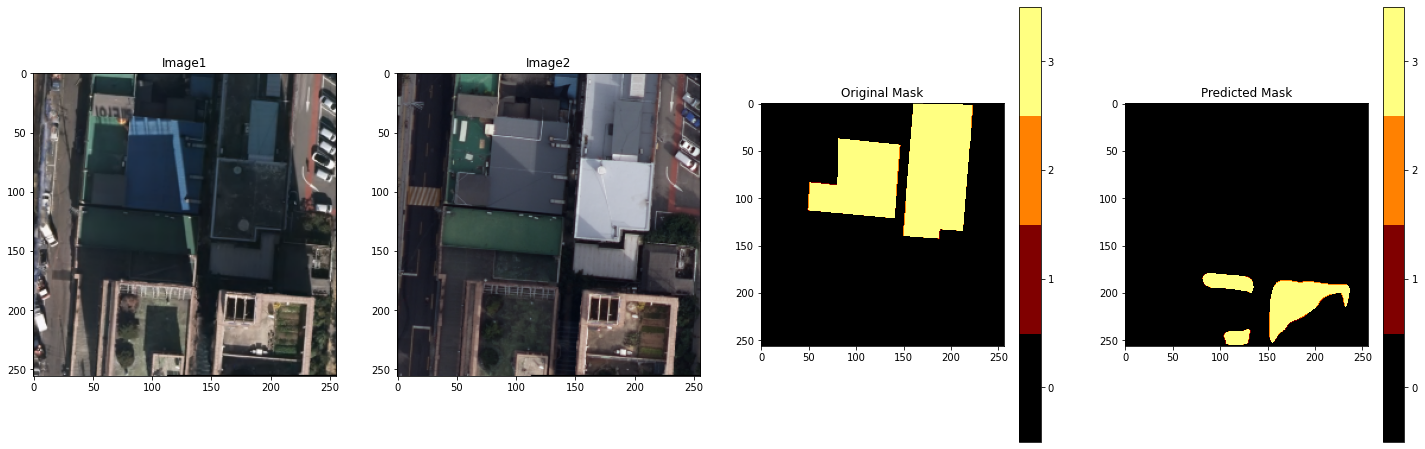

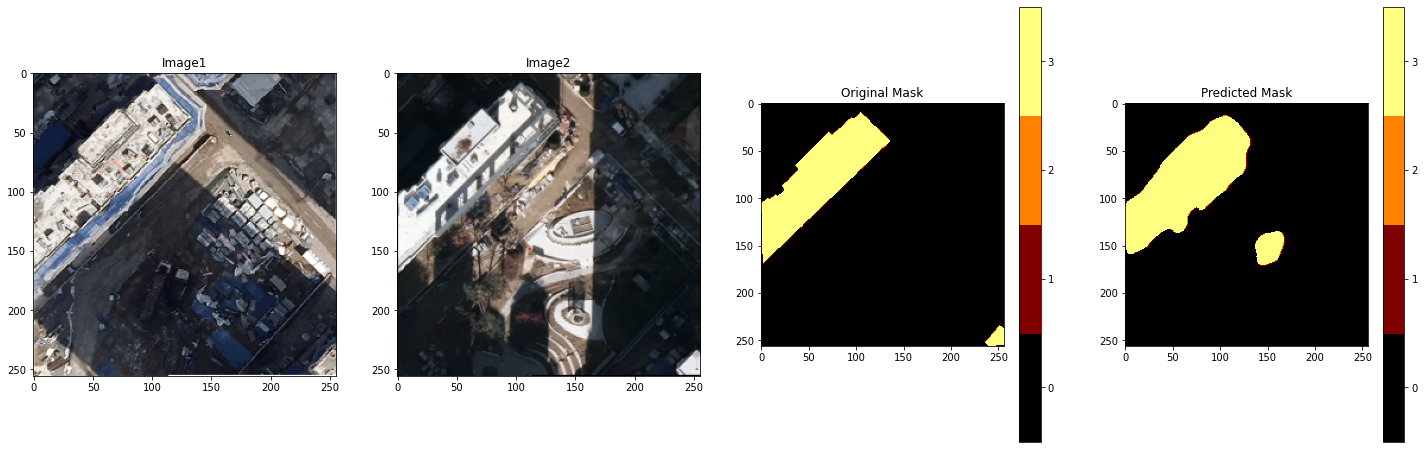

KeyboardInterrupt: ignored

In [ ]:
best_model = torch.load('./best_y2_COLAB.pth')

with torch.no_grad():
  best_model.eval()

  for (x1, x2, y, fname) in valid_y2_loader:
    x1, x2 = x1.float(), x2.float()
    x1, x2 = x1.to(DEVICE), x2.to(DEVICE)
    best_model = best_model.to(DEVICE)

    y_pred = best_model.forward(x1, x2)

    if not isinstance(y_pred, torch.Tensor): 
      y_pred = y_pred[-1]

    _, y_pred = torch.max(y_pred, dim = 1)
    y_pred = y_pred.squeeze().cpu().numpy()

    x1, x2 = x1.type(torch.ByteTensor).squeeze(), x2.type(torch.ByteTensor).squeeze()
    y = y.squeeze()
    plt.figure(figsize = (25, 8))
    plt.subplot(141)
    plt.title('Image1')
    plt.imshow(x1.permute(1, 2, 0))

    plt.subplot(142)
    plt.title('Image2')
    plt.imshow(x2.permute(1, 2, 0))

    plt.subplot(143)
    plt.title('Original Mask')
    plt.imshow(y, cmap = discrete_cmap(4, 'afmhot'))
    plt.colorbar(ticks = range(4))
    plt.clim(-0.5, 3.5)
        
    plt.subplot(144)
    plt.title('Predicted Mask')
    plt.imshow(y_pred, cmap = discrete_cmap(4, 'afmhot'))
    plt.colorbar(ticks = range(4))
    plt.clim(-0.5, 3.5)
    plt.show()